# Reconocimiento de células infectadas por malaria

En este fichero trabajaremos con un dataset de imágenes de células. Nuestro objetivo será detectar si una célula está infectada por la malaria. Lo primero que hacemos es importar las librerías necesarias para desarrollar el trabajo.

In [1]:
import tensorflow as tf
import os
import skimage.data as imd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import collections
import keras
from keras import layers
from keras import models
keras.__version__

Using TensorFlow backend.


'2.2.4'

## Preparación de los datos

A continuación, procedemos a la carga de los datos. Preparamos todas las imágenes y sus etiquetas.

In [2]:
def load_ml_data():
    labels = []
    images = []
    file_names = [os.path.join("cell_images/Parasitized", f)
                     for f in os.listdir("cell_images/Parasitized")
                     if f.endswith(".png")]
        
    for f in file_names:
        images.append(imd.imread(f))
        labels.append(0)
    
    file_names = [os.path.join("cell_images/Uninfected", f)
                    for f in os.listdir("cell_images/Uninfected")
                    if f.endswith(".png")]
        
    for f in file_names:
        img=mpimg.imread(f)
        images.append(img)
        labels.append(1)
        
    return images, labels

In [3]:
images, labels = load_ml_data()

Dividimos el dataset en subsets de entrenamiento y validación.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.33, random_state=42)

In [5]:
images = np.array(X_train)
labels = np.array(y_train)

La variables *images* y *labels* tienen una única dimensión, ya que son arrays.

In [6]:
images.ndim

1

Aunque el dataset está formado por 27558 imágenes, lo hemos dividido en dos subsets. De esta forma, tenemos un *subset de entrenamiento* y un *subset de test o validación*. El subset de entrenamiento está formado por 18463 imágenes.

In [7]:
images.size

18463

Vamos a ver qué dimensiones tienen nuestras imágenes.

In [8]:
# ver que se han almacenado correctamente los pixeles
images[2][45].shape

(148, 3)

In [9]:
import random
rand_signs = random.sample(range(0, len(labels)), 6)
rand_signs

[8568, 6014, 6501, 14380, 4405, 11362]

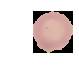

Forma:(145, 136, 3), min:0.0, max:0.8901960849761963


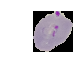

Forma:(151, 145, 3), min:0, max:215


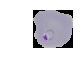

Forma:(112, 118, 3), min:0, max:205


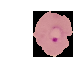

Forma:(148, 127, 3), min:0, max:227


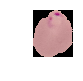

Forma:(139, 118, 3), min:0, max:224


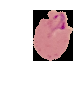

Forma:(151, 118, 3), min:0, max:231


In [10]:
import matplotlib.pyplot as plt
for i in range(len(rand_signs)):
    temp_im = images[rand_signs[i]]
    plt.subplot(1,6,i+1)
    plt.axis("off")
    imgplot = plt.imshow(temp_im)
    plt.subplots_adjust(wspace = 0.5)
    plt.show()
    print("Forma:{0}, min:{1}, max:{2}".format(temp_im.shape,
                                               temp_im.min(),
                                               temp_im.max()))

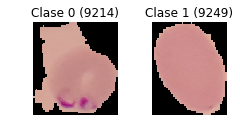

In [11]:
unique_labels = set(labels)
plt.figure(figsize=(16,16))
i = 1
for label in unique_labels:
    temp_im = images[list(labels).index(label)]
    plt.subplot(8,8, i)
    plt.axis("off")
    plt.title("Clase {0} ({1})".format(label, list(labels).count(label)))
    i +=1
    plt.imshow(temp_im)
plt.show()

---
Como hemos visto, las imágenes tienen distintos tamaños. Sin embargo, para poder trabajar con comodidad, necesitamos transformarlas, de manera que todas tengan las mismas dimensiones.

In [12]:
from skimage import transform

In [13]:
w = 9999 
h = 9999
for image in images:
    if image.shape[0] < h:
        h = image.shape[0]
    if image.shape[1] < w:
        w = image.shape[1]
print("Tamaño mínimo: {0}x{1}".format(h,w))

Tamaño mínimo: 40x49


Transformaremos todas las imágenes para que tengan el mismo tamaño. De este modo, cumplimos dos objetivos:


1.   Todas las imágenes tienen el **mismo tamaño**, lo que nos permite operar con ellas sin problemas añadidos
2.   Todas las imágenes son **matrices**, pudiendo así alimentar capas convolucionales de dos dimensiones. En nuestro caso, las imágenes se transformarán en matrices de **48x48**.

La elección de transformar las imágenes en matrices de 48x48 está condicionada por las **capas convolucionales** y de ***pooling***, que dividirán las imágenes a la mitad de su tamaño al procesarlas.



In [14]:
images48 = [transform.resize(image, (48,48)) for image in images]
data = np.asarray(images48)
data = data.reshape(len(data), 48, 48, 3)

C:\Users\Sergio Cavero\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Sergio Cavero\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Las imágenes tienen ahora tres dimensiones (48, 48, 3). Esto nos indica que son matrices de 48x48 con tres canales. Es decir, las imágenes están a color, cada píxel está formado por una combinación de los tres clores primarios.

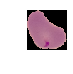

Forma:(48, 48, 3), min:0.0, max:0.8552747140522878


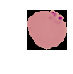

Forma:(48, 48, 3), min:0.0, max:0.8944087009803929


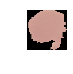

Forma:(48, 48, 3), min:0.0, max:0.8439951073378318


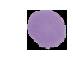

Forma:(48, 48, 3), min:0.0, max:0.7645016480237243


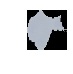

Forma:(48, 48, 3), min:0.0, max:0.8010774219874293


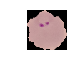

Forma:(48, 48, 3), min:0.0, max:0.8521650326797385


In [15]:
rand_signs = random.sample(range(0, len(labels)), 6)
rand_signs
for i in range(len(rand_signs)):
    temp_im = images48[rand_signs[i]]
    plt.subplot(1,6,i+1)
    plt.axis("off")
    plt.imshow(temp_im)
    plt.subplots_adjust(wspace = 0.5)
    plt.show()
    print("Forma:{0}, min:{1}, max:{2}".format(temp_im.shape,
                                               temp_im.min(),
                                               temp_im.max()))

---
## Arquitectura y entrenamiento
A continuación, procedemos a construir la red neuronal mediante la librería Keras. Nuestra red estará compuesta por **dos capas convolucionales**. Tras las capas convolucionales, tendremos una** capa de salida con dos neuronas** y activación ***softmax***.

In [16]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(48, 48,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 44, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 64)          0         
Total params: 53,696
Trainable params: 53,696
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.add(layers.Flatten())
model.add(layers.Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 44, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10370     
Total params: 64,066
Trainable params: 64,066
Non-trainable params: 0
_________________________________________________________________


Compilamos la red neuronal para que Keras la construya, indicándole cuáles son las métricas que queremos, el método de optimización, etc.

In [18]:
from keras import optimizers
from keras.utils import to_categorical
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error',
              optimizer=sgd,
              metrics=['accuracy'])

In [19]:
labels

array([1, 1, 0, ..., 0, 1, 1])

In [20]:
data.shape
labels = to_categorical(labels)
labels

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

---
Entrenamos la red neuronal

In [21]:
batch_size = 50
epochs = 10
model.fit(data, labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1
          )

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
18463/18463 [==============================] - 67s 4ms/step - loss: 0.2245 - acc: 0.6322: 5
Epoch 2/10
18463/18463 [==============================] - 67s 4ms/step - loss: 0.1848 - acc: 0.7253
Epoch 3/10
18463/18463 [==============================] - 68s 4ms/step - loss: 0.1134 - acc: 0.8521
Epoch 4/10
18463/18463 [==============================] - 70s 4ms/step - loss: 0.0606 - acc: 0.9283
Epoch 5/10
18463/18463 [==============================] - 69s 4ms/step - loss: 0.0483 - acc: 0.9426
Epoch 6/10
18463/18463 [==============================] - 69s 4ms/step - loss: 0.0432 - acc: 0.9482
Epoch 7/10
18463/18463 [==============================] - 69s 4ms/step - loss: 0.0406 - acc: 0.9508
Epoch 8/10
18463/18463 [==============================] - 69s 4ms/step - loss: 0.0390 - acc: 0.9518
Epoch 9/10
18463/18463 [==============================] - 69s 4ms/step - loss: 0.0376 - acc: 0.9543
Epoch 10/10
18463/18463 [========================

---
Por último, representaremos de manera visual algunas de las imágenes y sus predicciones. En color verde se pueden observar las células cuya predicción ha sido acertada, mientras que las predicciones erróneas se han representado en color rojo.

In [22]:
images = np.array(X_test)
labels = np.array(y_test)
images48 = [transform.resize(image, (48,48)) for image in images]

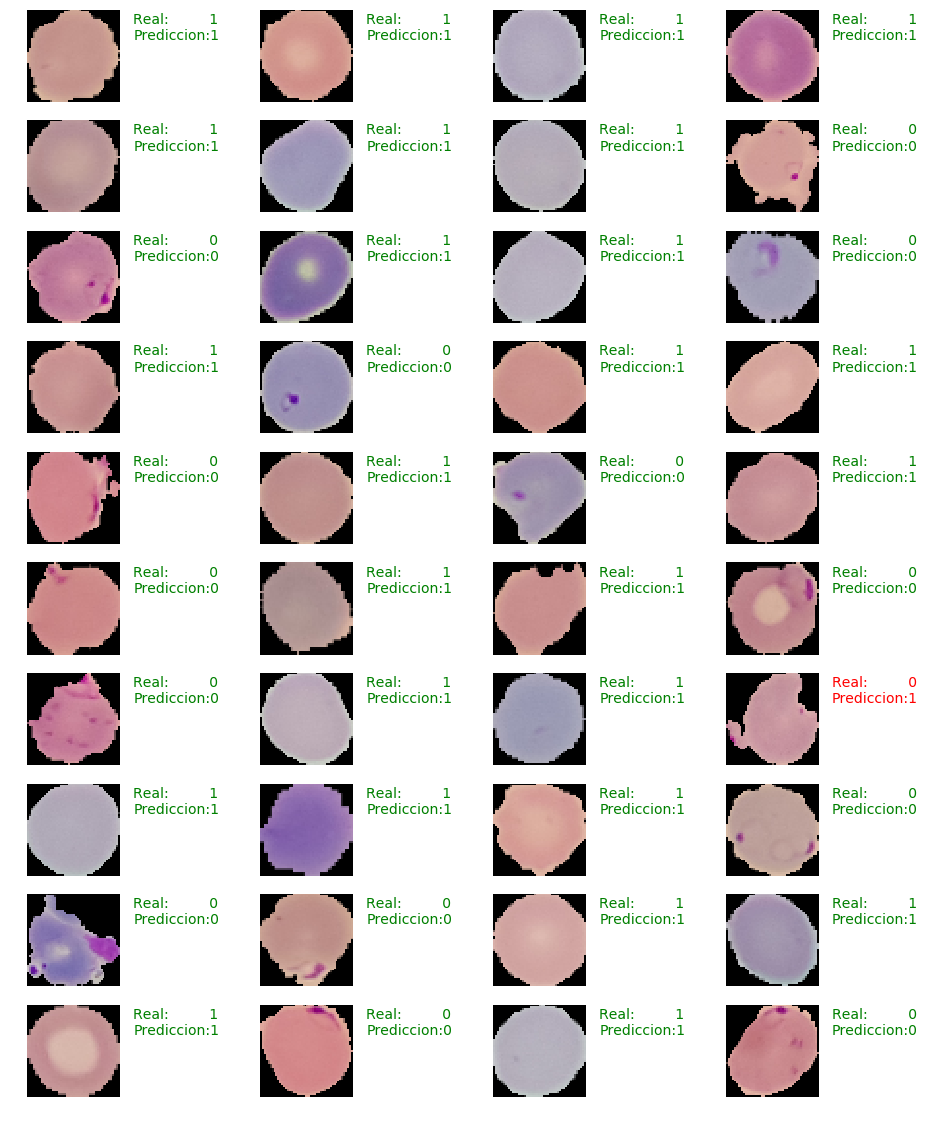

In [23]:
sample_idx = random.sample(range(len(images48)), 40)
sample_images = [images48[i] for i in sample_idx]
sample_labels = [labels[i] for i in sample_idx]
data = np.asarray(sample_images)
data = data.reshape(len(data), 48, 48, 3)
predi =  model.predict_classes(data)
plt.figure(figsize=(16,20))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    plt.subplot(10,4,i+1)
    plt.axis("off")
    color = "green" if truth==predi[i] else "red"
    plt.text(55,15, "Real:         {0}\nPrediccion:{1}".format(truth, predi[i]),
            fontsize = 14, color = color)
    plt.imshow(sample_images[i], cmap="gray")
plt.show()